**Лабоаторная работа № 1**

Выполнил студент группы ББМО-02-23

**Курченко Иван Дмитриевич**

### 1. Скачивание репозитория

In [1]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project.git

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 39.15 MiB/s, done.
Resolving deltas: 100% (27/27), done.


### 2. Изменение текущего каталога

In [2]:
%cd /content/EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


### 3. Импортирование библиотек и модулей

In [3]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms

from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack


### 4. Подключение Google Диска

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 5. Номер относительно группы

In [5]:
rand_seed={"18"}

### 6. Определение параметров для набора данных MNIST

1. Определение среднего значения:
   - `mnist_mean = 0.5`: Эта переменная определяет среднее значение (mean) для изображений в наборе данных MNIST. В контексте обработки изображений, среднее значение часто используется для нормализации данных, чтобы улучшить сходимость и производительность нейронных сетей.

2. Определение стандартного отклонения:
   - `mnist_std = 0.5`: Эта переменная задает стандартное отклонение (standard deviation) для изображений в MNIST. Как и среднее значение, стандартное отклонение также применяется в процессе нормализации, чтобы изменить масштаб значений пикселей изображения, что помогает ускорить процесс обучения и повысить стабильность.

3. Определение размерности изображений:
   - `mnist_dim = 28`: Эта переменная показывает размерность изображений в наборе данных MNIST. Каждое изображение в наборе данных имеет размер 28x28 пикселей. Это важно учитывать при построении сети и обработке входных данных, так как размер массива входных данных должен соответствовать размеру изображений.

In [6]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

### 7. Определение устройства для вычислений

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 8. Обработка и подготовка данных для набора MNIST

1. Получение границ для обрезки:
   - `mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)`: Эта строка вызывает функцию `get_clip_bounds`, которая рассчитывает минимальные и максимальные значения для данных, опираясь на заданные среднее значение, стандартное отклонение и размерность изображений. Эти значения могут применяться для нормализации изображений, чтобы убедиться, что они находятся в подходящем диапазоне.

2. Перенос границ на устройство:
   - `mnist_min = mnist_min.to(device)` и `mnist_max = mnist_max.to(device)`: Эти строки переносят значения `mnist_min` и `mnist_max` на ранее определенное вычислительное устройство (GPU или CPU). Это позволяет использовать эти значения непосредственно в вычислениях, проводимых на выбранном устройстве.

3. Трансформации для обучения:
   - `mnist_tf = transforms.Compose([.])`: Эта строка создает последовательность трансформаций для подготовки данных. Она включает преобразование изображения в тензор и нормализацию с использованием заданных среднего значения и стандартного отклонения.
   - `mnist_tf_train = transforms.Compose([.])`: Добавляется дополнительная трансформация, которая включает в себя случайное горизонтальное отражение (`RandomHorizontalFlip`) изображений для улучшения разнообразия обучающего набора данных.

4. Обратные трансформации:
   - `mnist_tf_inv = transforms.Compose([.])`: Эта строка создает последовательность трансформаций, которая инвертирует предыдущую нормализацию, позволяя восстановить исходные значения пикселей из нормализованных изображений. Это полезно, когда необходимо визуализировать изображения.

5. Создание датасета:
   - `mnist_temp = datasets.MNIST(.)`: Эта строка создает объект датасета MNIST для обучения, загружая данные с указанного пути и применяя к ним трансформации обучения.
   - `mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])`: В этой строке происходит разделение загруженного датасета на обучающую (`mnist_train`) и валидационную (`mnist_val`) выборки, состоящие из 50,000 и 10,000 примеров соответственно.
   
6. Создание тестового датасета:
   - `mnist_test = datasets.MNIST(.)`: Эта строка создает объект тестового датасета для MNIST, загружая данные из того же источника, но с трансформациями, применяемыми только для тестирования.

In [8]:
mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)

mnist_min = mnist_min.to(device)

mnist_max = mnist_max.to(device)

mnist_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])

mnist_tf_train = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])

mnist_tf_inv = transforms.Compose([ transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0)])

mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)

mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])

mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 488kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.12MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



### 9. Определение параметров для набора данных CIFAR-10

1. Среднее значение:
   - `cifar_mean = [0.491, 0.482, 0.447]`: Эта переменная задает средние значения (mean) для цветовых каналов (RGB) изображений в наборе данных CIFAR-10. Каждое значение соответствует среднему по каждому из трех цветовых каналов. Эти параметры используются для нормализации изображений, что помогает в процессе обучения, поскольку нейронные сети работают лучше на данных, отличия которых минимальны.

2. Стандартное отклонение:
   - `cifar_std = [0.202, 0.199, 0.201]`: Эта переменная определяет стандартные отклонения (standard deviation) для цветовых каналов изображений в CIFAR-10. Как и средние значения, стандартные отклонения необходимы для нормализации данных, чтобы укладывать значения пикселей в удобный диапазон и помочь модели более эффективно обучаться.

3. Размерность изображений:
   - `cifar_dim = 32`: Эта переменная указывает размер изображения в наборе данных CIFAR-10. Каждое изображение имеет размер 32x32 пикселя, что также важно для определения структуры модели и обработки входных данных.

In [9]:
cifar_mean = [0.491, 0.482, 0.447]

cifar_std = [0.202, 0.199, 0.201]

cifar_dim = 32


### 10. Обработка и подготовка данных для набора CIFAR-10

In [10]:
cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)

cifar_min = cifar_min.to(device)

cifar_max = cifar_max.to(device)

cifar_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize( mean=cifar_mean, std=cifar_std)])

cifar_tf_train = transforms.Compose([ transforms.RandomCrop( size=cifar_dim, padding=4),transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=cifar_mean,std=cifar_std)])

cifar_tf_inv = transforms.Compose([ transforms.Normalize( mean=[0.0, 0.0, 0.0], std=np.divide(1.0,cifar_std)), transforms.Normalize( mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])

cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True,transform=cifar_tf_train)

cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])

cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)

cifar_classes = ['deer', 'dog' 'airplane', 'automobile', 'ship', 'bird', 'cat', 'frog', 'horse', 'truck']


100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


### 11. Определение параметров загрузки данных

1. Размер батча:
   - `batch_size = 64`: Эта переменная определяет размер батча (batch size), что означает количество примеров, которые будут обрабатываться одновременно во время обучения или оценки модели. Размер батча влияет на производительность и скорость обучения. Значение 64 указывает на то, что модель будет обновлять свои параметры после обработки 64 примеров, что является достаточно распространенной практикой в задачах глубокого обучения.

2. Количество рабочих процессов:
   - `workers = 4`: Эта переменная указывает количество процессов (или потоков), которые будут использованы для загрузки данных. Использование нескольких рабочих процессов может значительно ускорить процесс загрузки, особенно при работе с большими наборами данных, так как данные могут загружаться параллельно, минимизируя время ожидания между эпохами обучения.

In [11]:
batch_size = 64
workers = 4

### 12. Создание загрузчиков данных с помощью DataLoader

In [12]:
mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### 13. Инициализация параметров для глубокого обучения

In [13]:
deep_args = [10, 10, 0.02, 50]

### 14. Выполнение атак на модель

In [14]:
fgsm_eps = 0.2

model = Net().to(device)

model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cpu')))

evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max,fgsm_eps, is_fgsm=True)

print('someprint')

evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model,cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()


FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us
someprint
DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms


<ipython-input-14-6e68bcbdd058>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth',map_location=torch.device('cp

### 15. Выполнение атак на модель LeNet для CIFAR-10

In [15]:
fgsm_eps = 0.1

model = LeNet_CIFAR().to(device)

model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))

evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max,
fgsm_eps, is_fgsm=True)

print('')

evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model,cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)

if device.type == 'cuda': torch.cuda.empty_cache()


FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-15-b0414236475d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device(

### 16. Определение параметров для глубокого обучения

In [16]:
deep_args = [10, 10, 0.02, 50]

### 17. Выполнение атаки FGSM на модель LeNet для MNIST

<ipython-input-17-5186bc9f55fd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/EEL6812_DeepFool_Project/weights/clean/mnist_lene

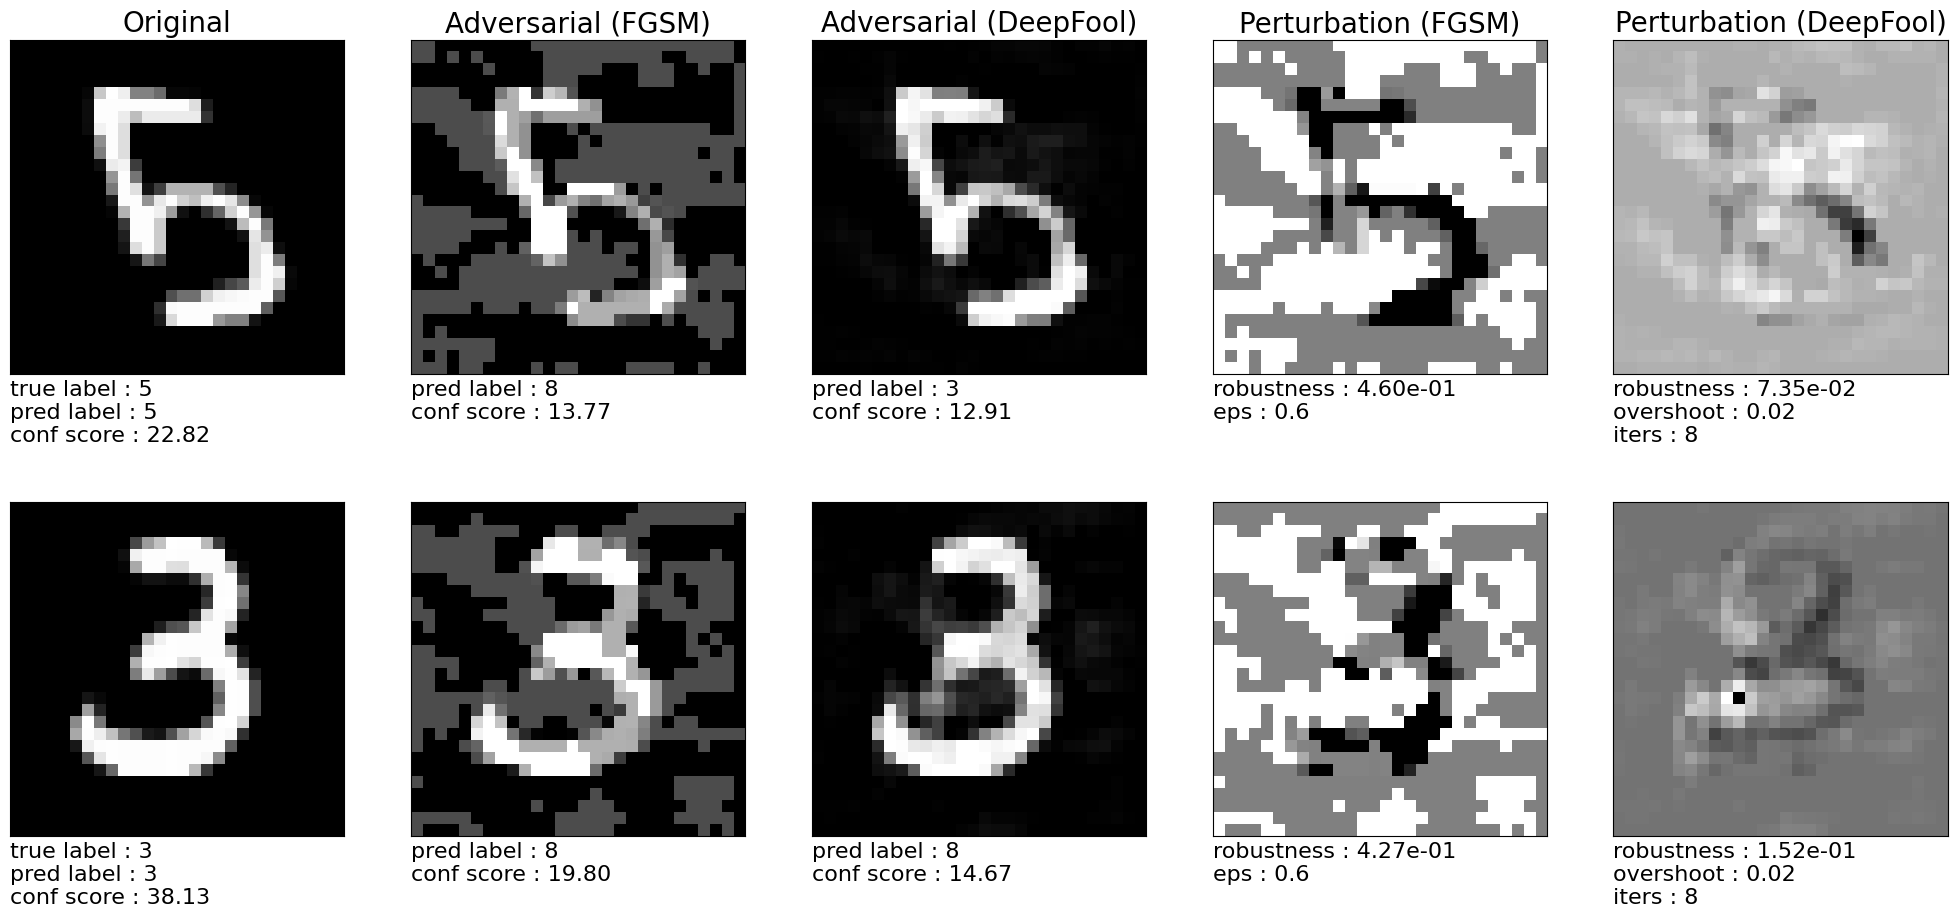

In [17]:
fgsm_eps = 0.6

model = LeNet_MNIST().to(device)

model.load_state_dict(torch.load('/content/EEL6812_DeepFool_Project/weights/clean/mnist_lenet.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max,
               fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()


### 18. Выполнение атаки FGSM на модель FC с одним скрытым слоем для MNIST

<ipython-input-18-6500a8777172>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


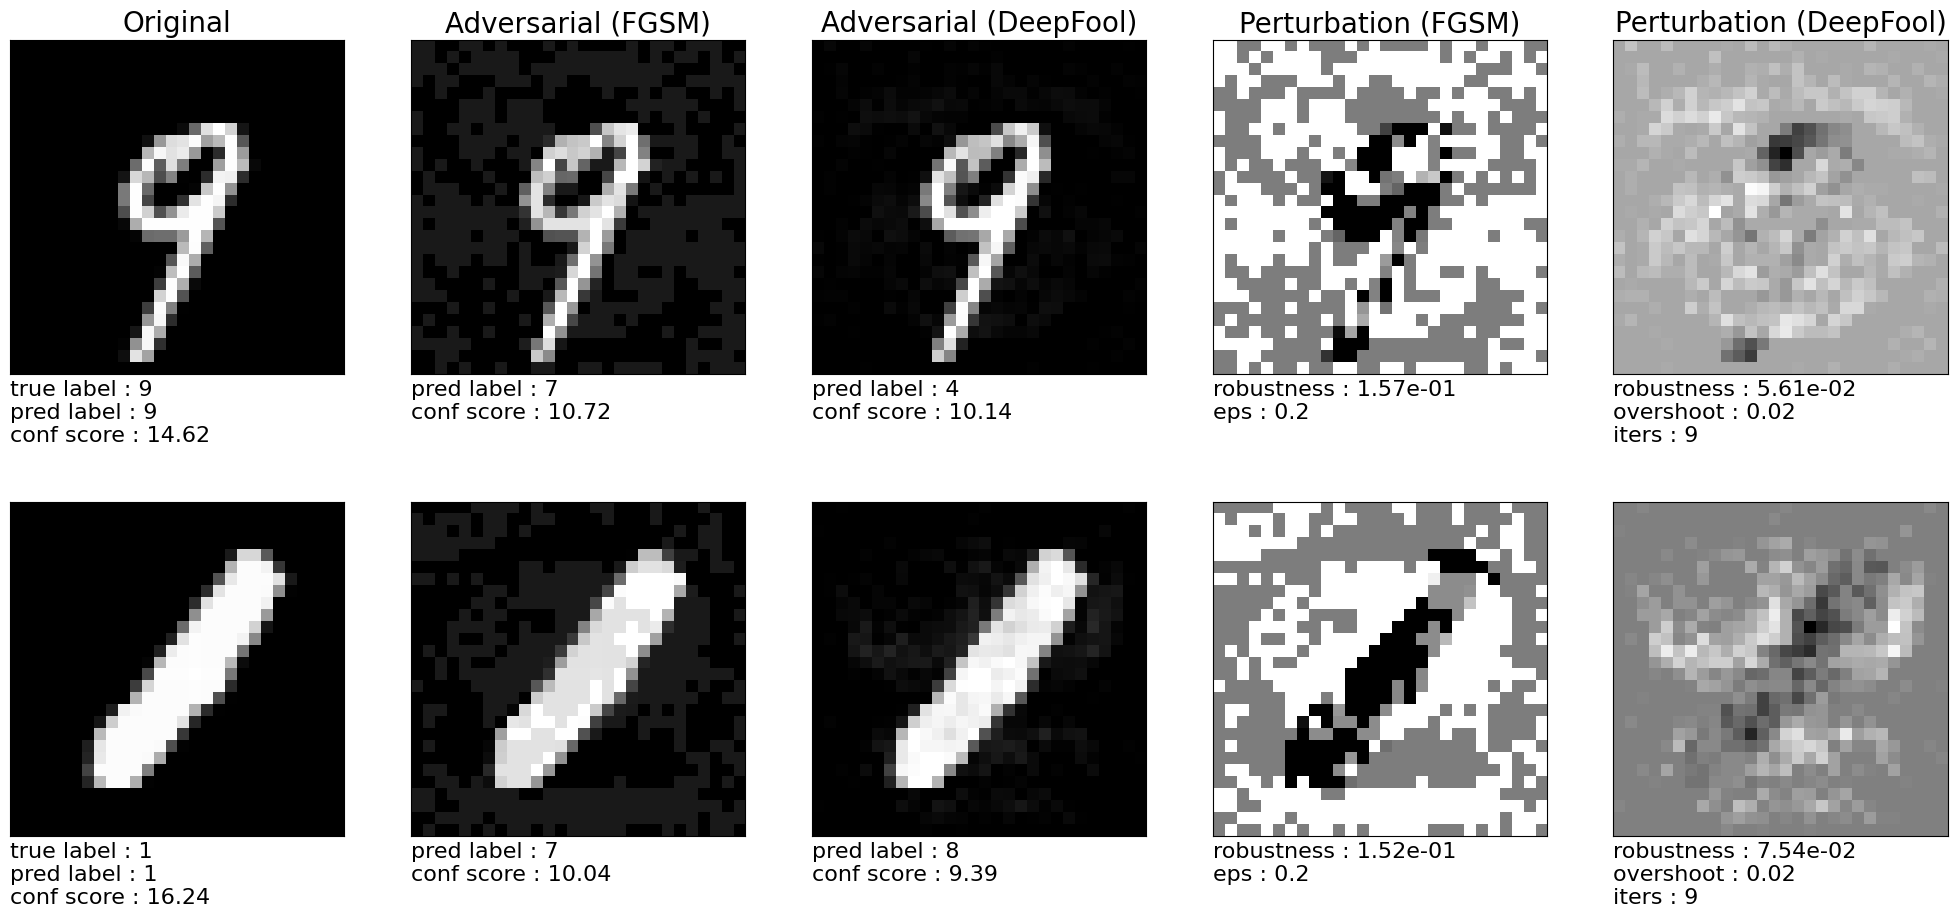

In [18]:
fgsm_eps = 0.2

model = FC_500_150().to(device)

model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,

               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

if device.type == 'cuda': torch.cuda.empty_cache()


### 19. Выполнение атаки FGSM на модель для CIFAR-10

<ipython-input-19-77adf8c089e0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


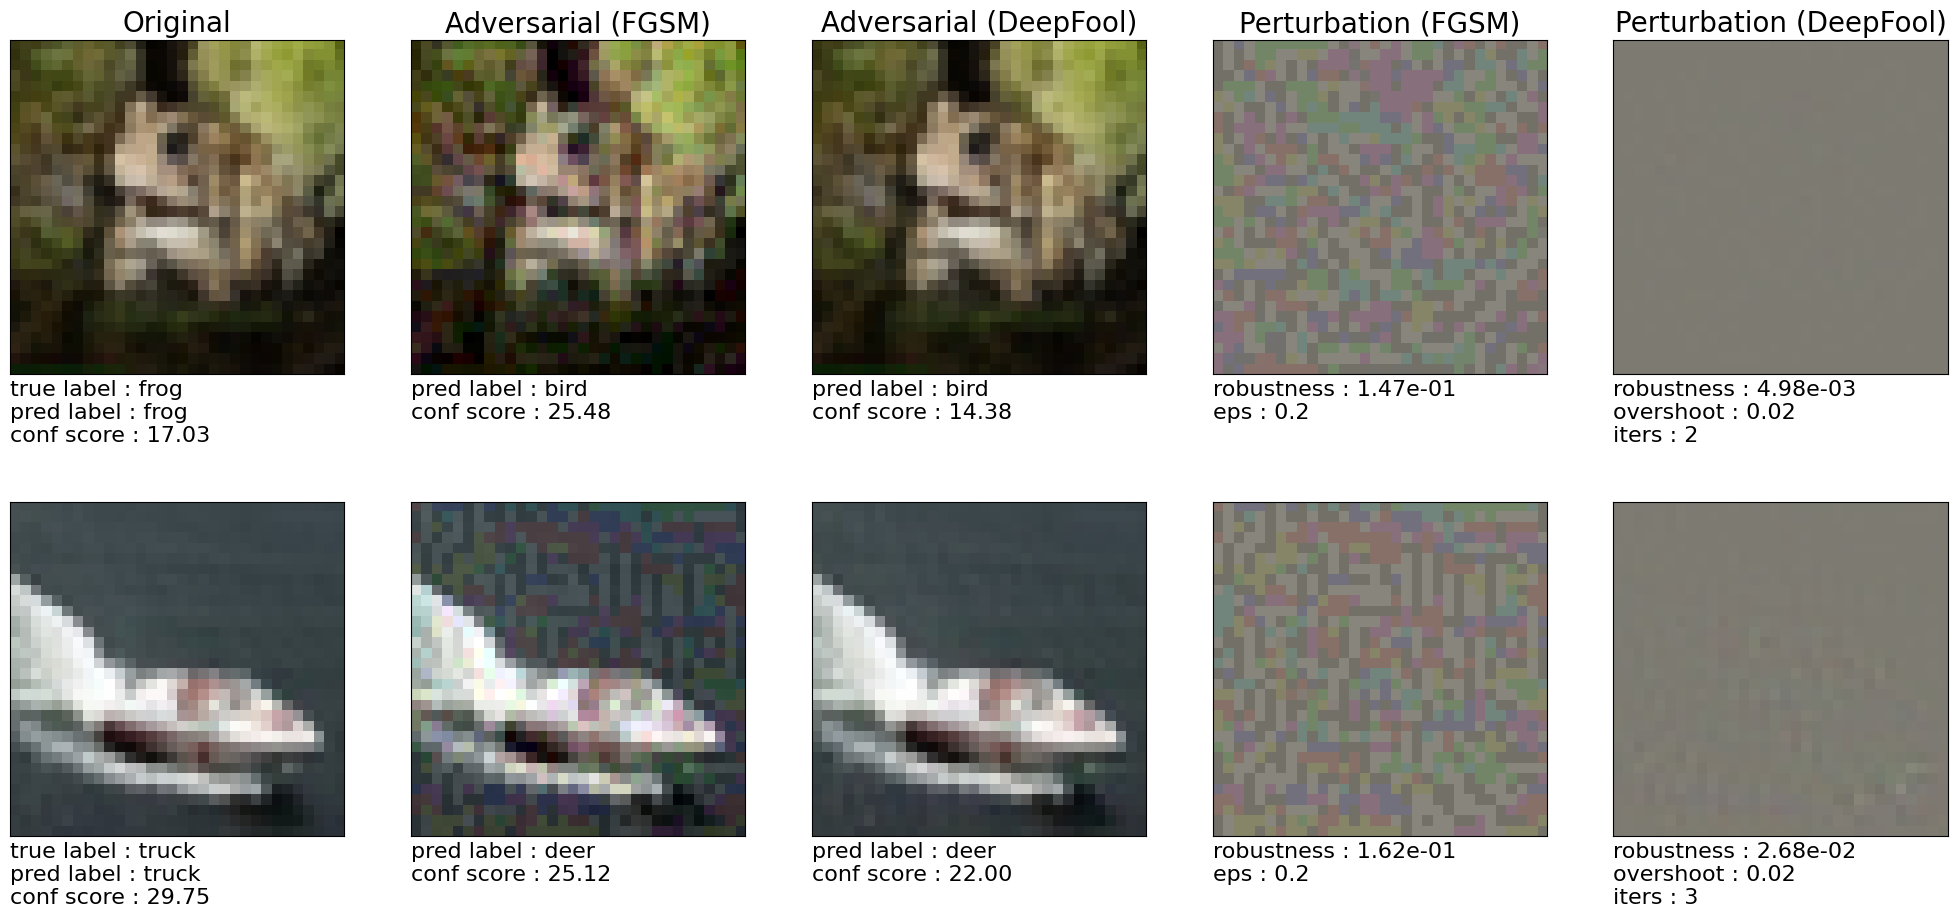

In [19]:
fgsm_eps = 0.2

model = Net().to(device)

model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,

               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

### 20. Выполнение атаки FGSM на модель LeNet для CIFAR-10

<ipython-input-20-79fd989ba557>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


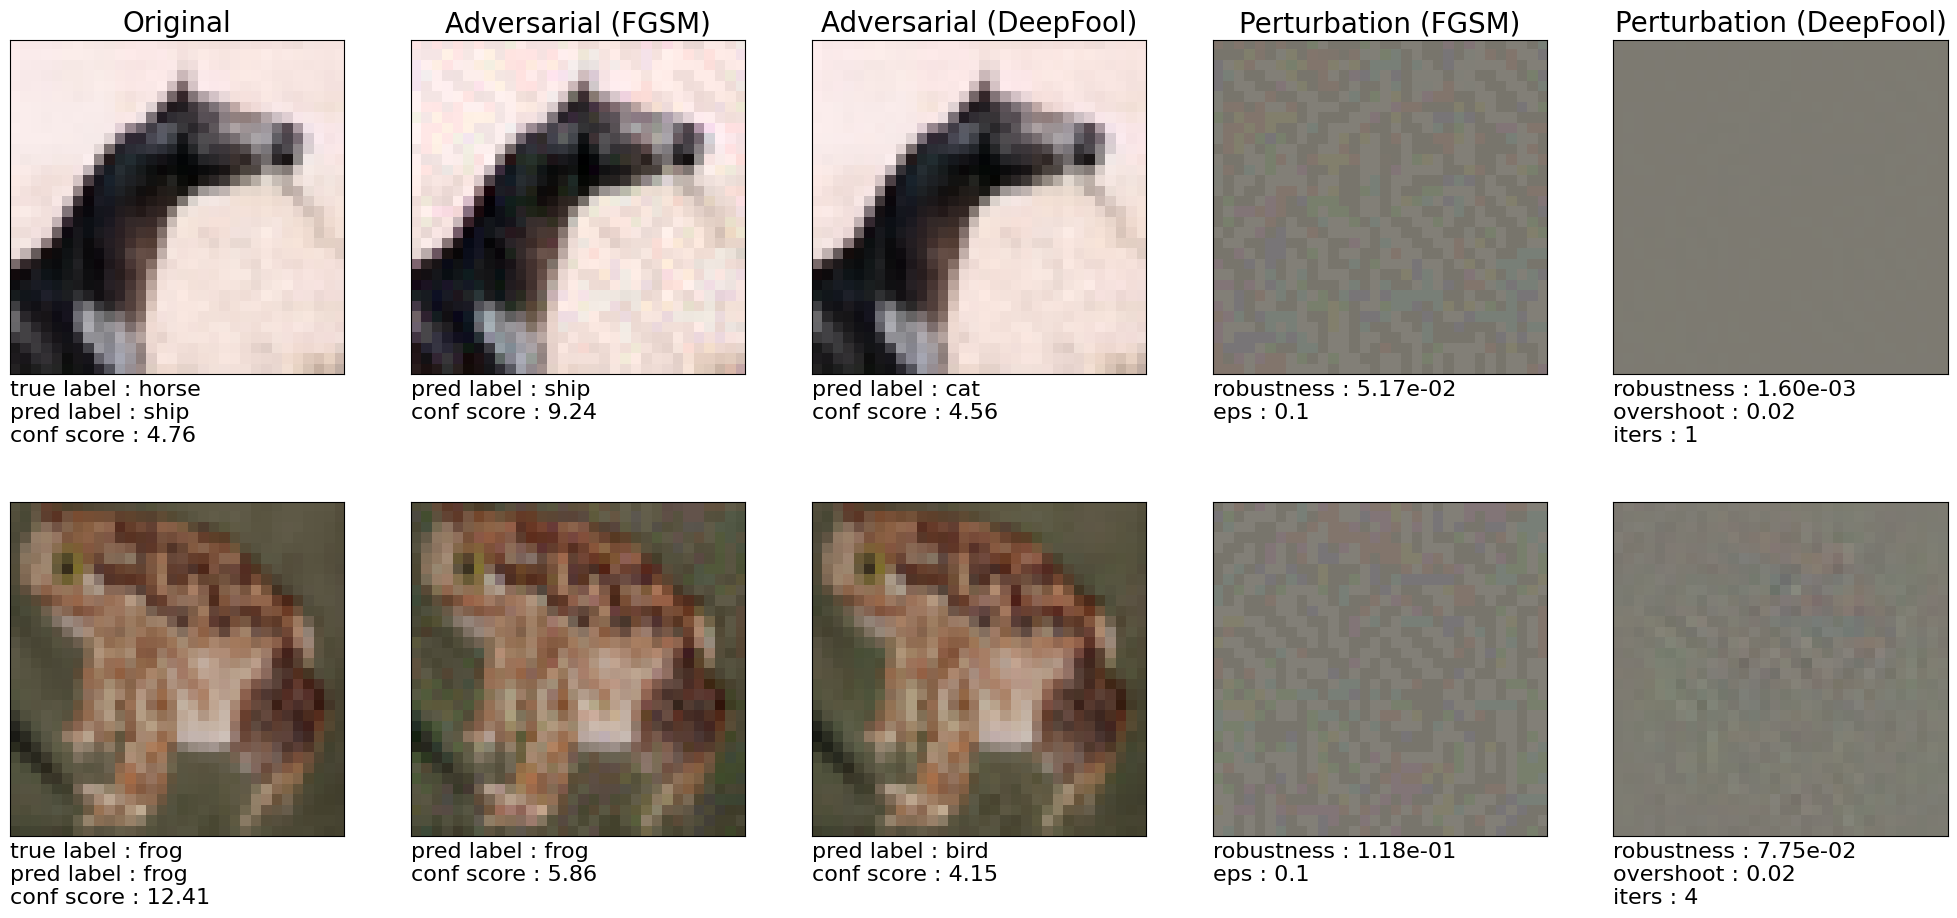

In [20]:
fgsm_eps = 0.1

model = LeNet_CIFAR().to(device)

model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))

display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args,
               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)

if device.type == 'cuda': torch.cuda.empty_cache()

### 21. Выполнение FGSM атак с различными значениями эпсилон на модель LeNet для MNIST

eps:  0.001


<ipython-input-21-b76926e5fa1e>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))


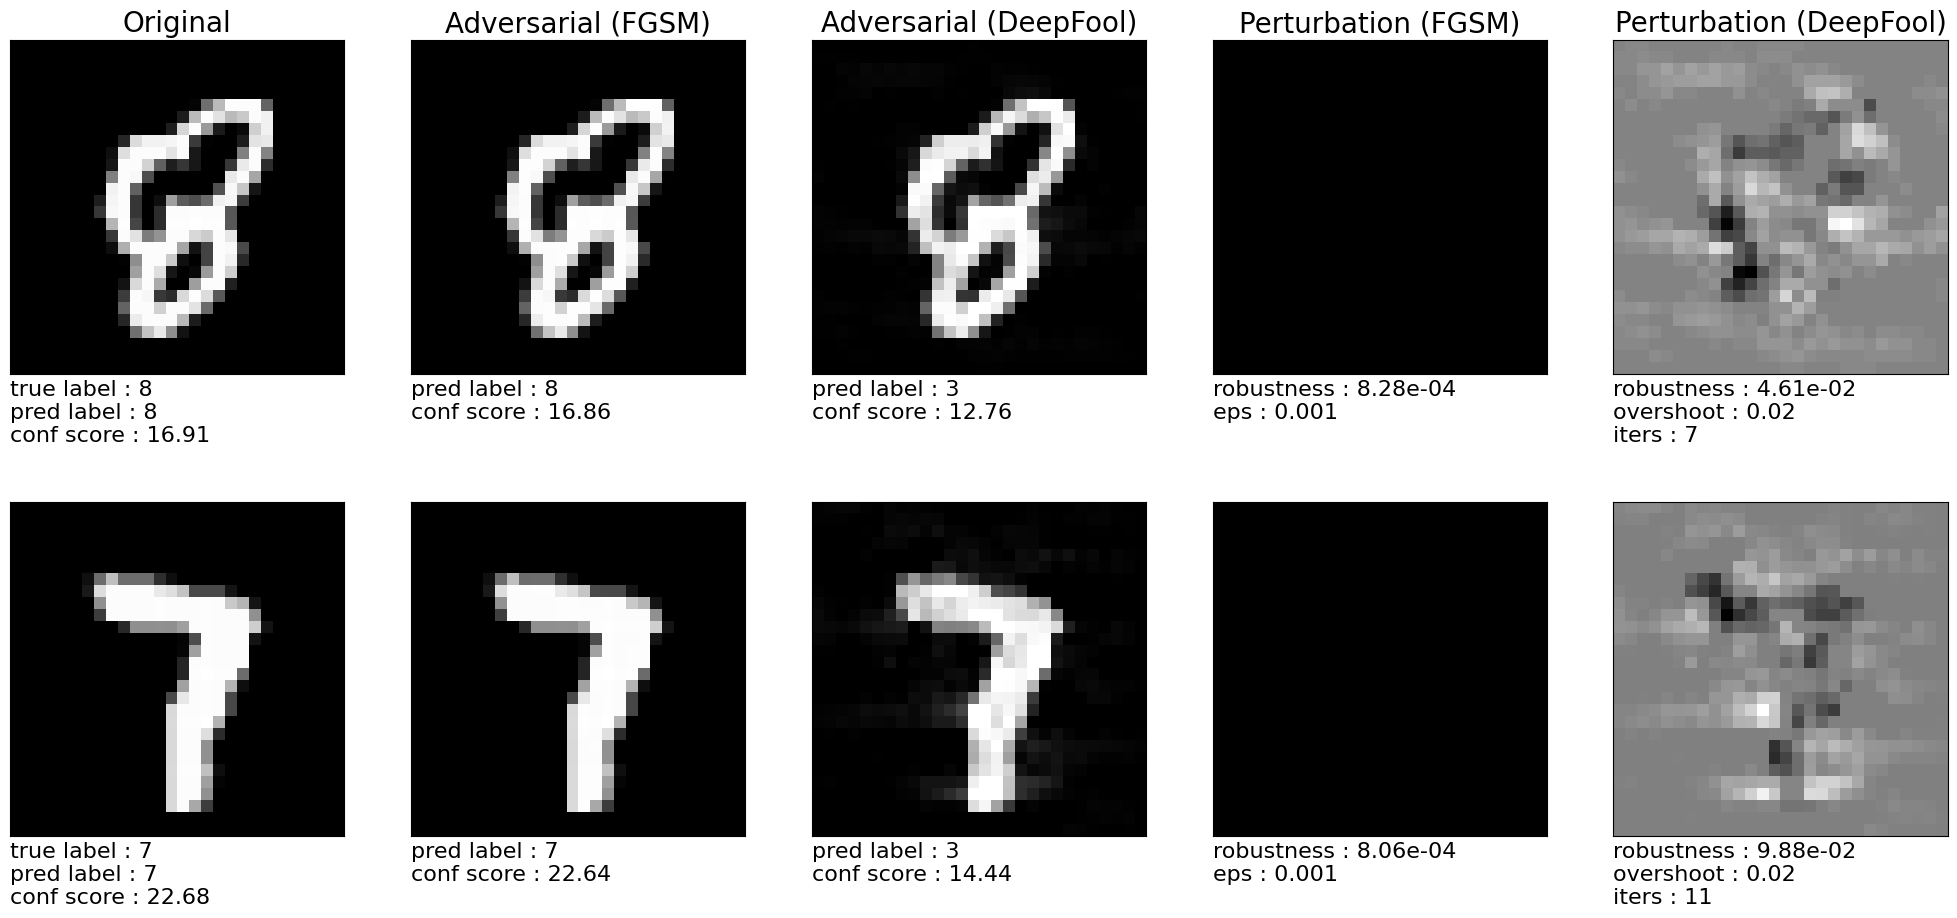

eps:  0.02


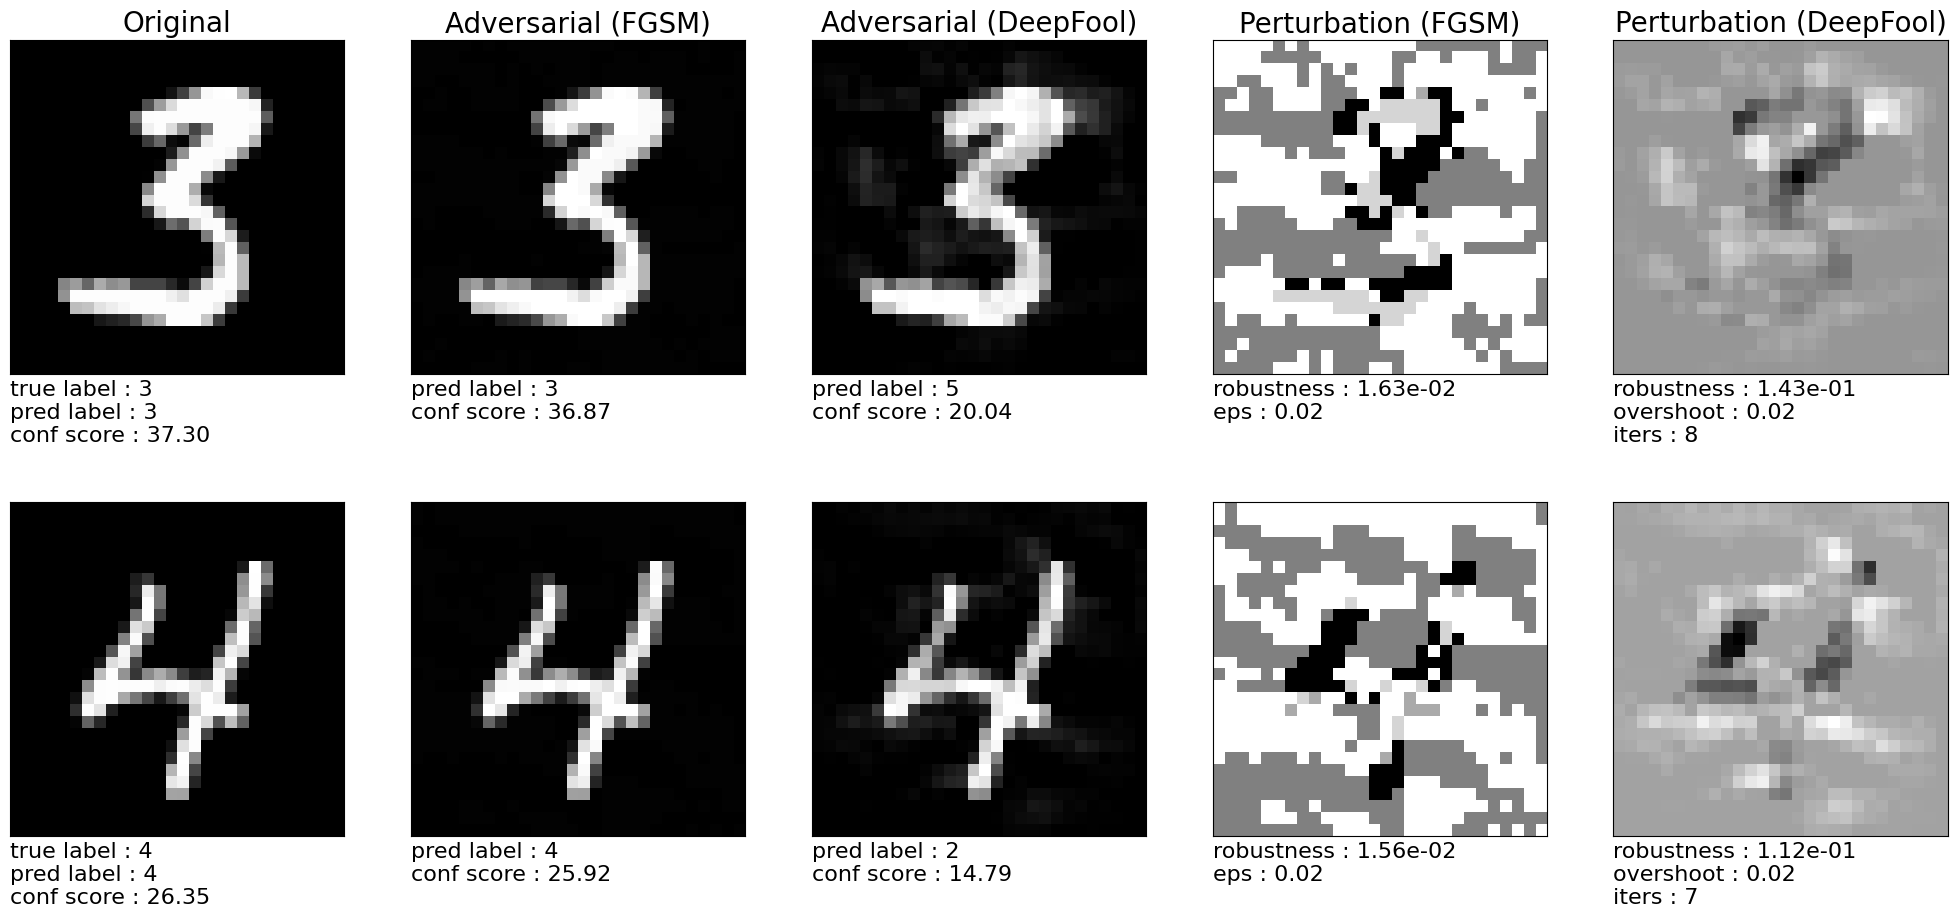

eps:  0.5


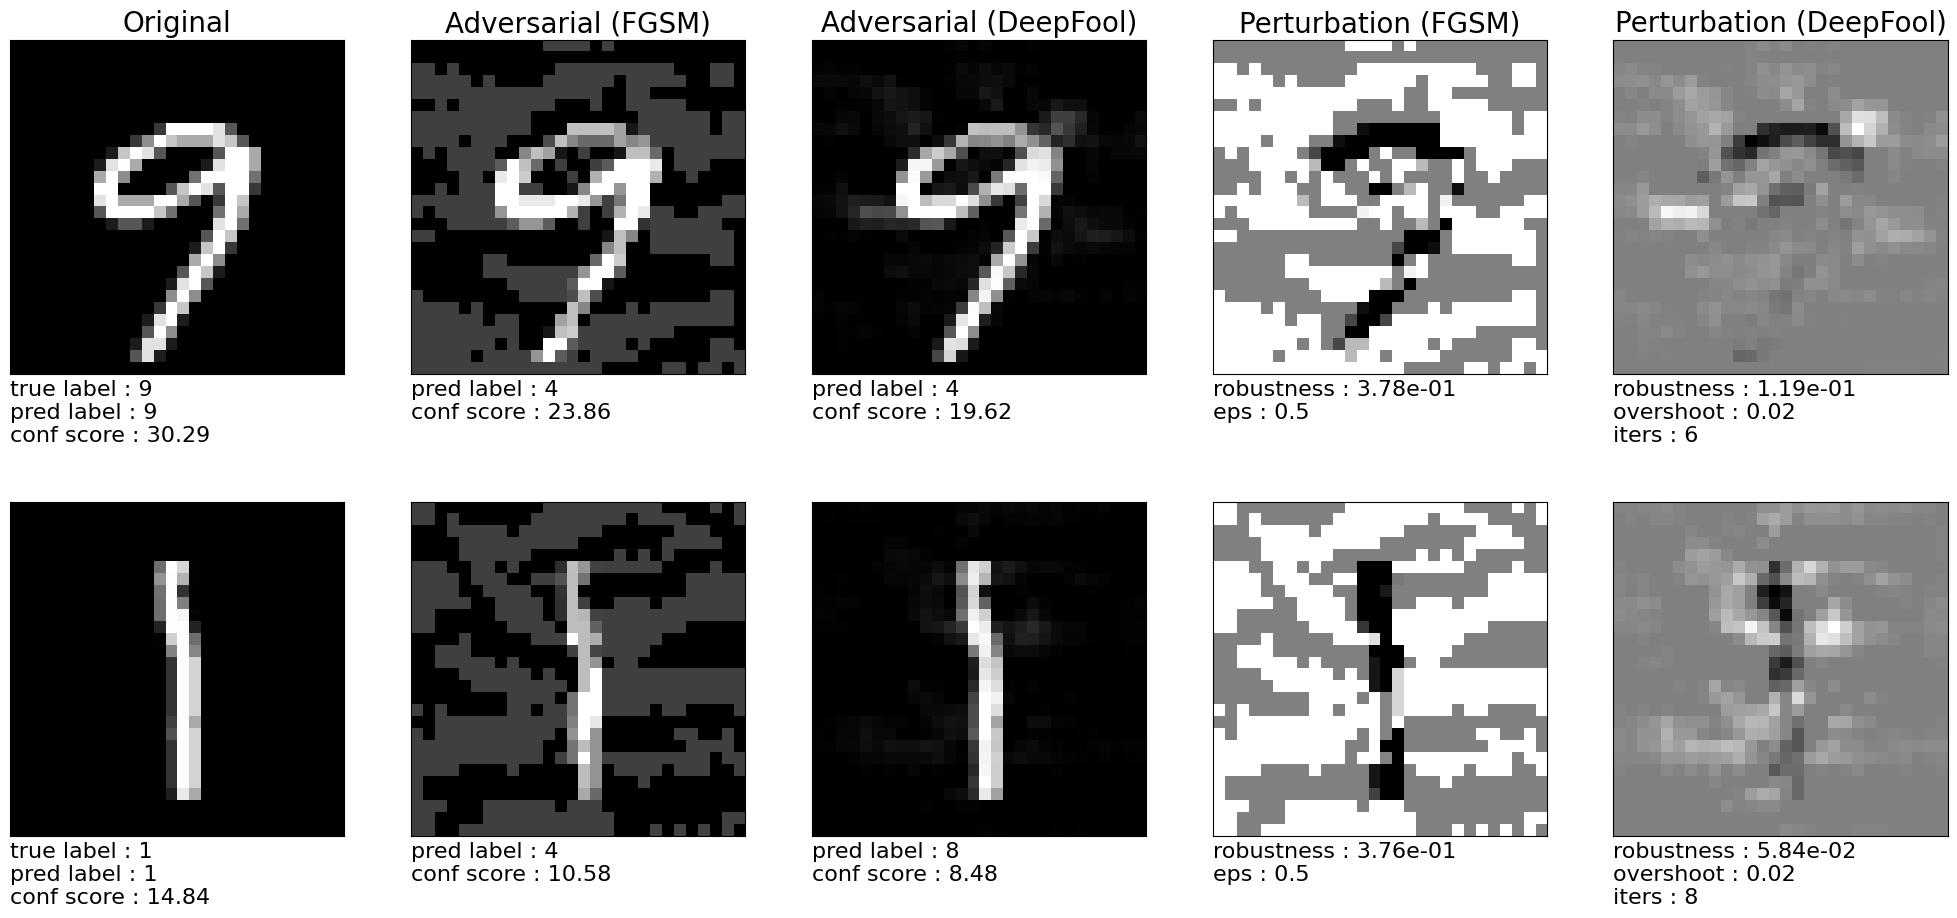

eps:  0.9


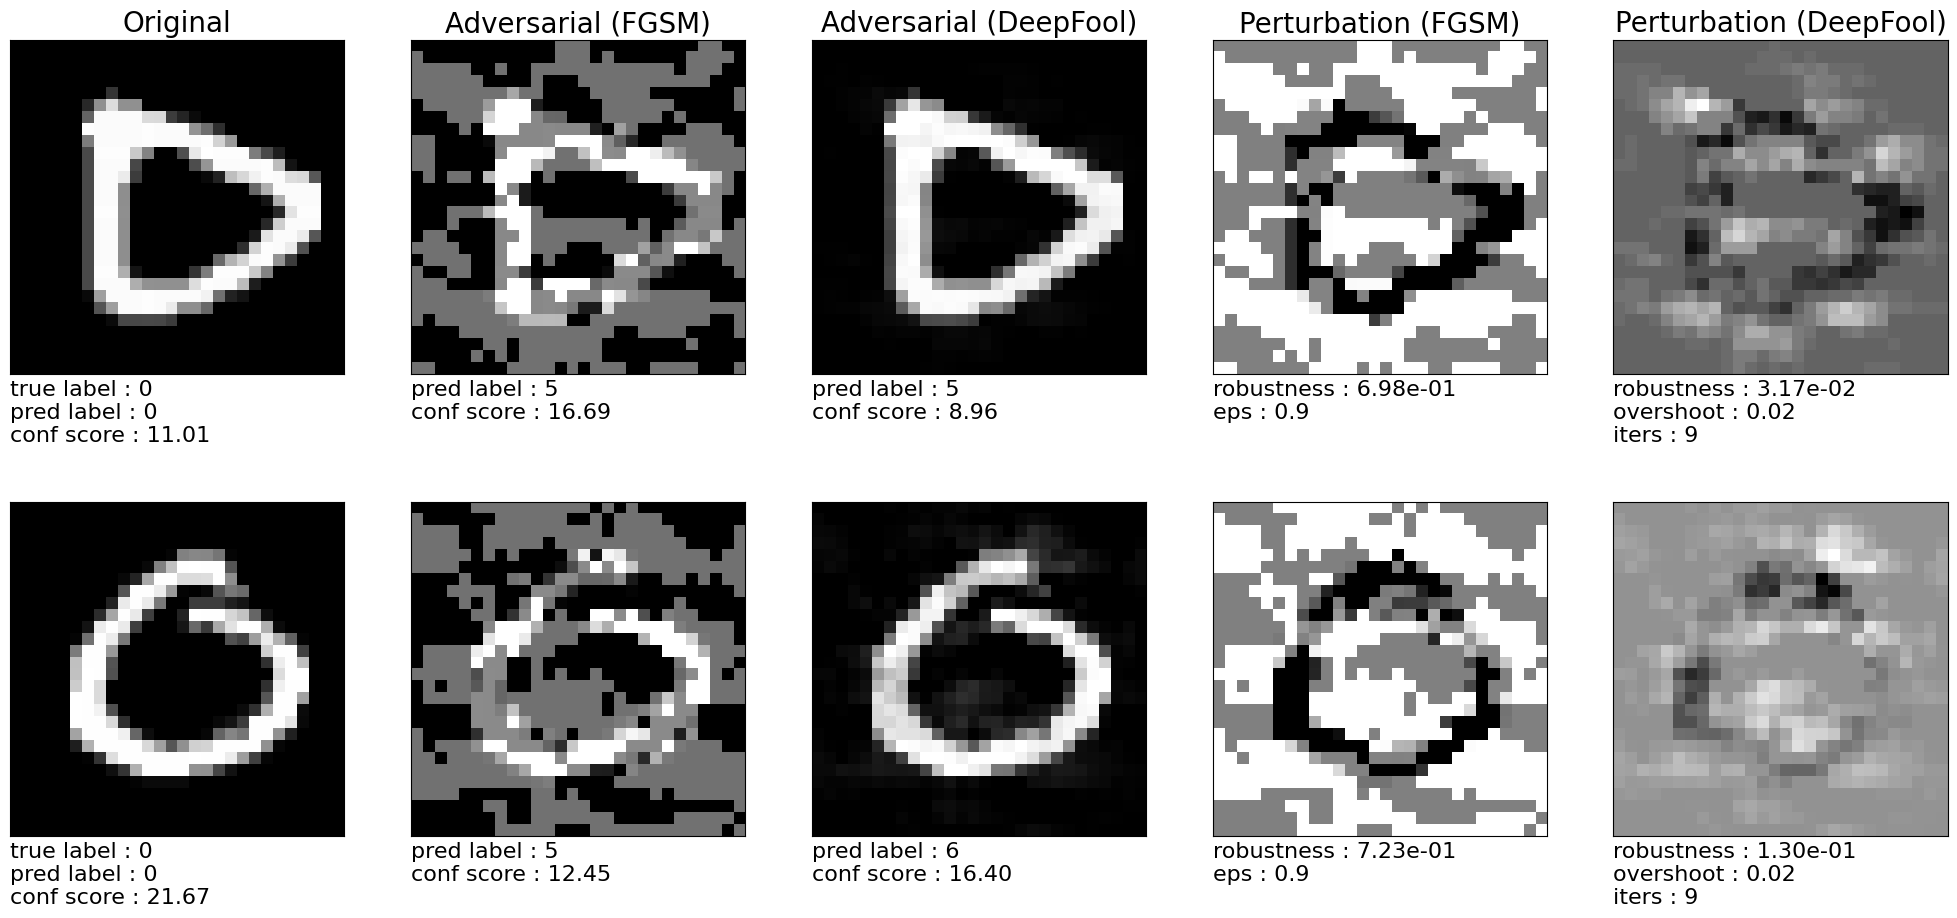

eps:  10


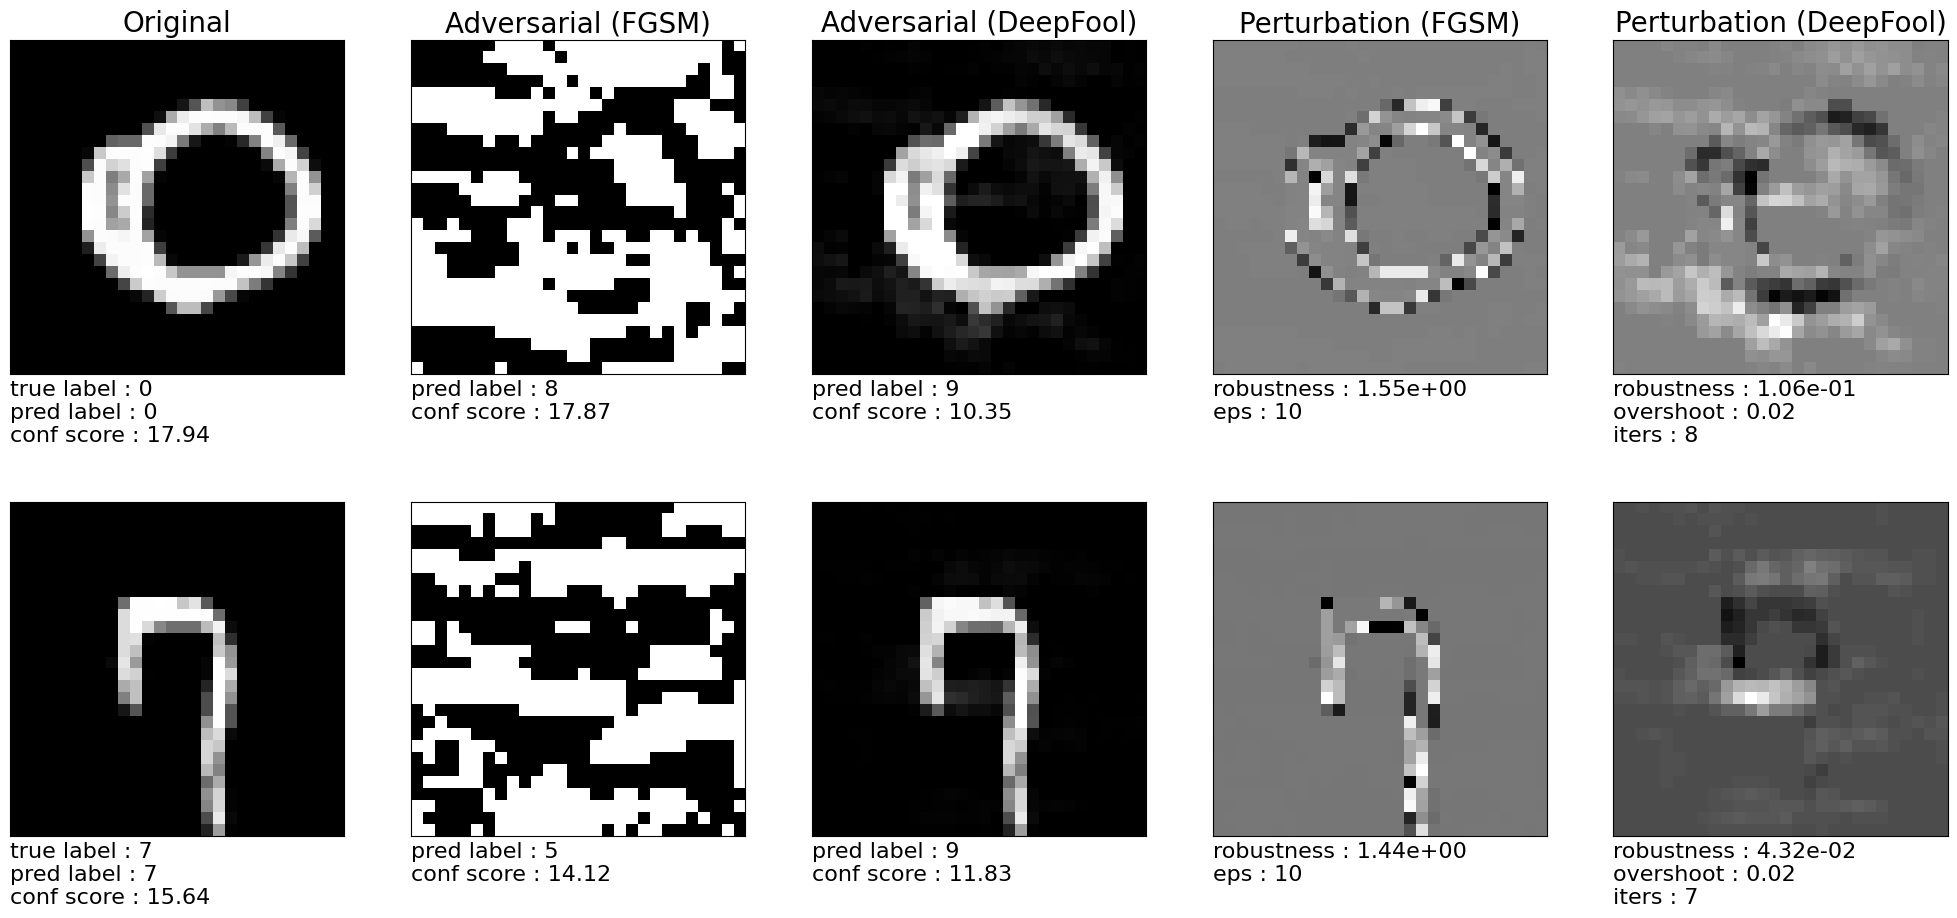

In [21]:
fgsm_eps_arr = [0.001, 0.02, 0.5, 0.9, 10]

for fgsm_eps in fgsm_eps_arr:
  print("eps: ", fgsm_eps)

  model = LeNet_MNIST().to(device)

  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max,
               fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

  if device.type == 'cuda': torch.cuda.empty_cache()

### 22. Цикл для выполнения FGSM атак с различными значениями эпсилон на модель FC

eps:  0.001


<ipython-input-23-e75e79e76802>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


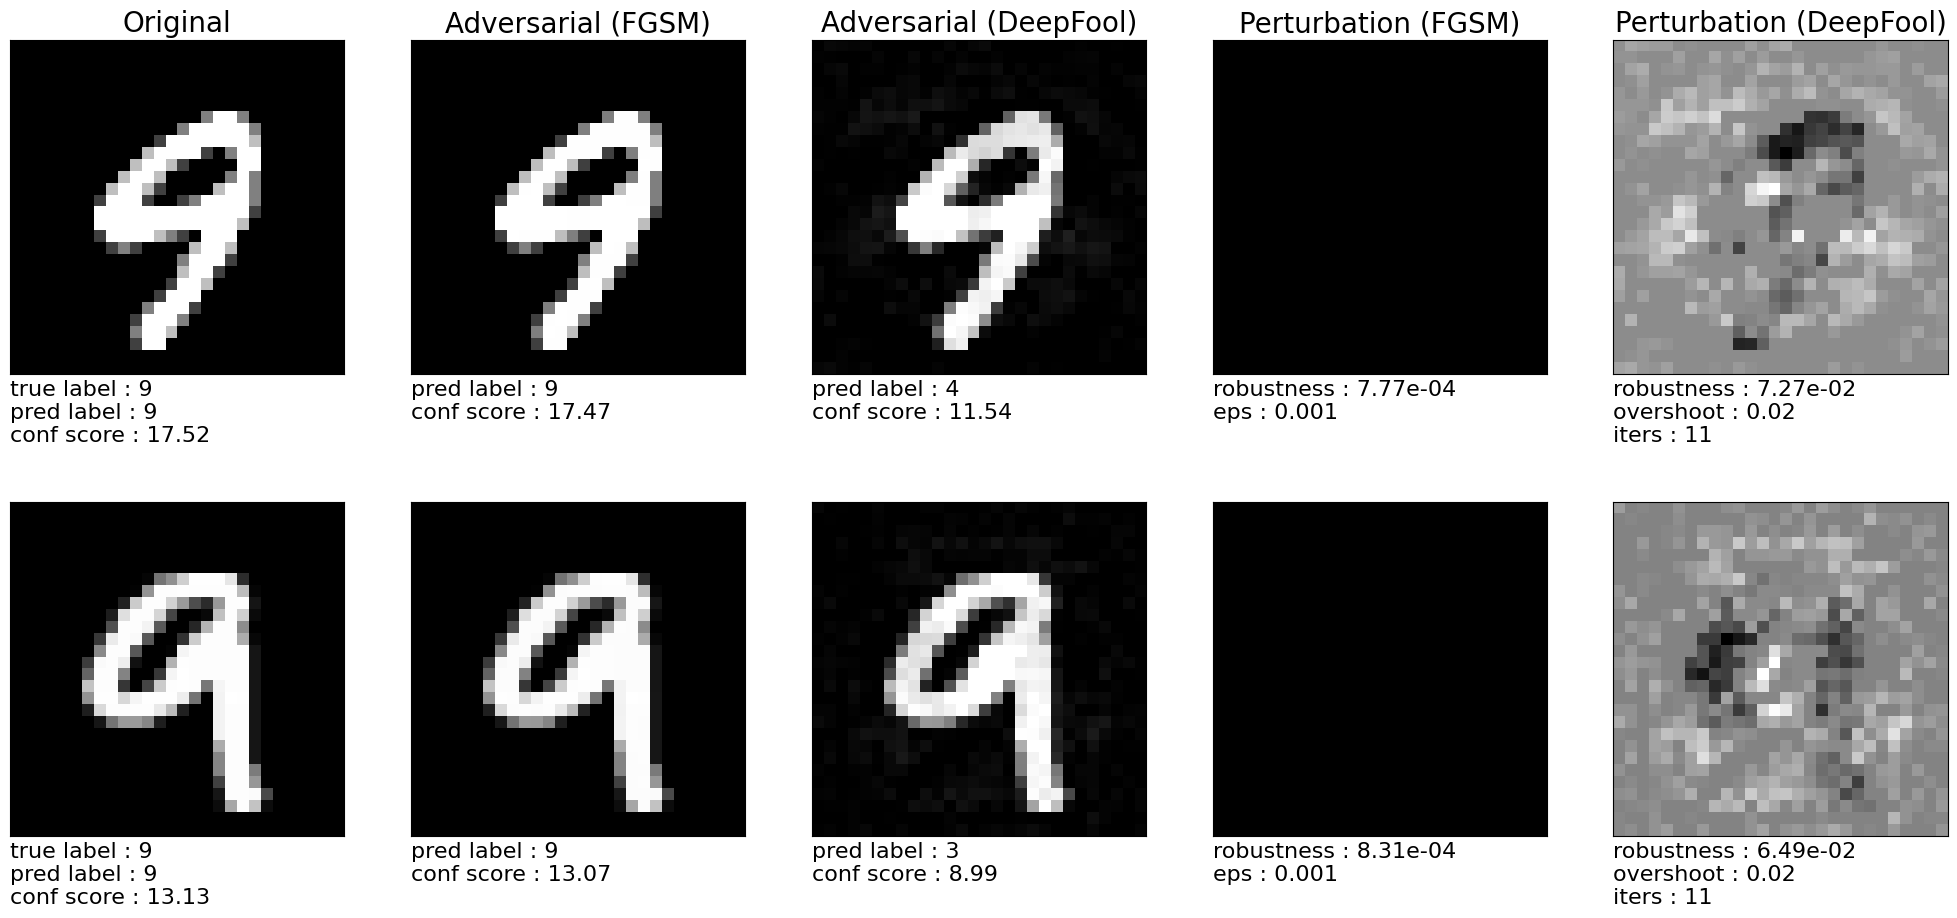

eps:  0.02


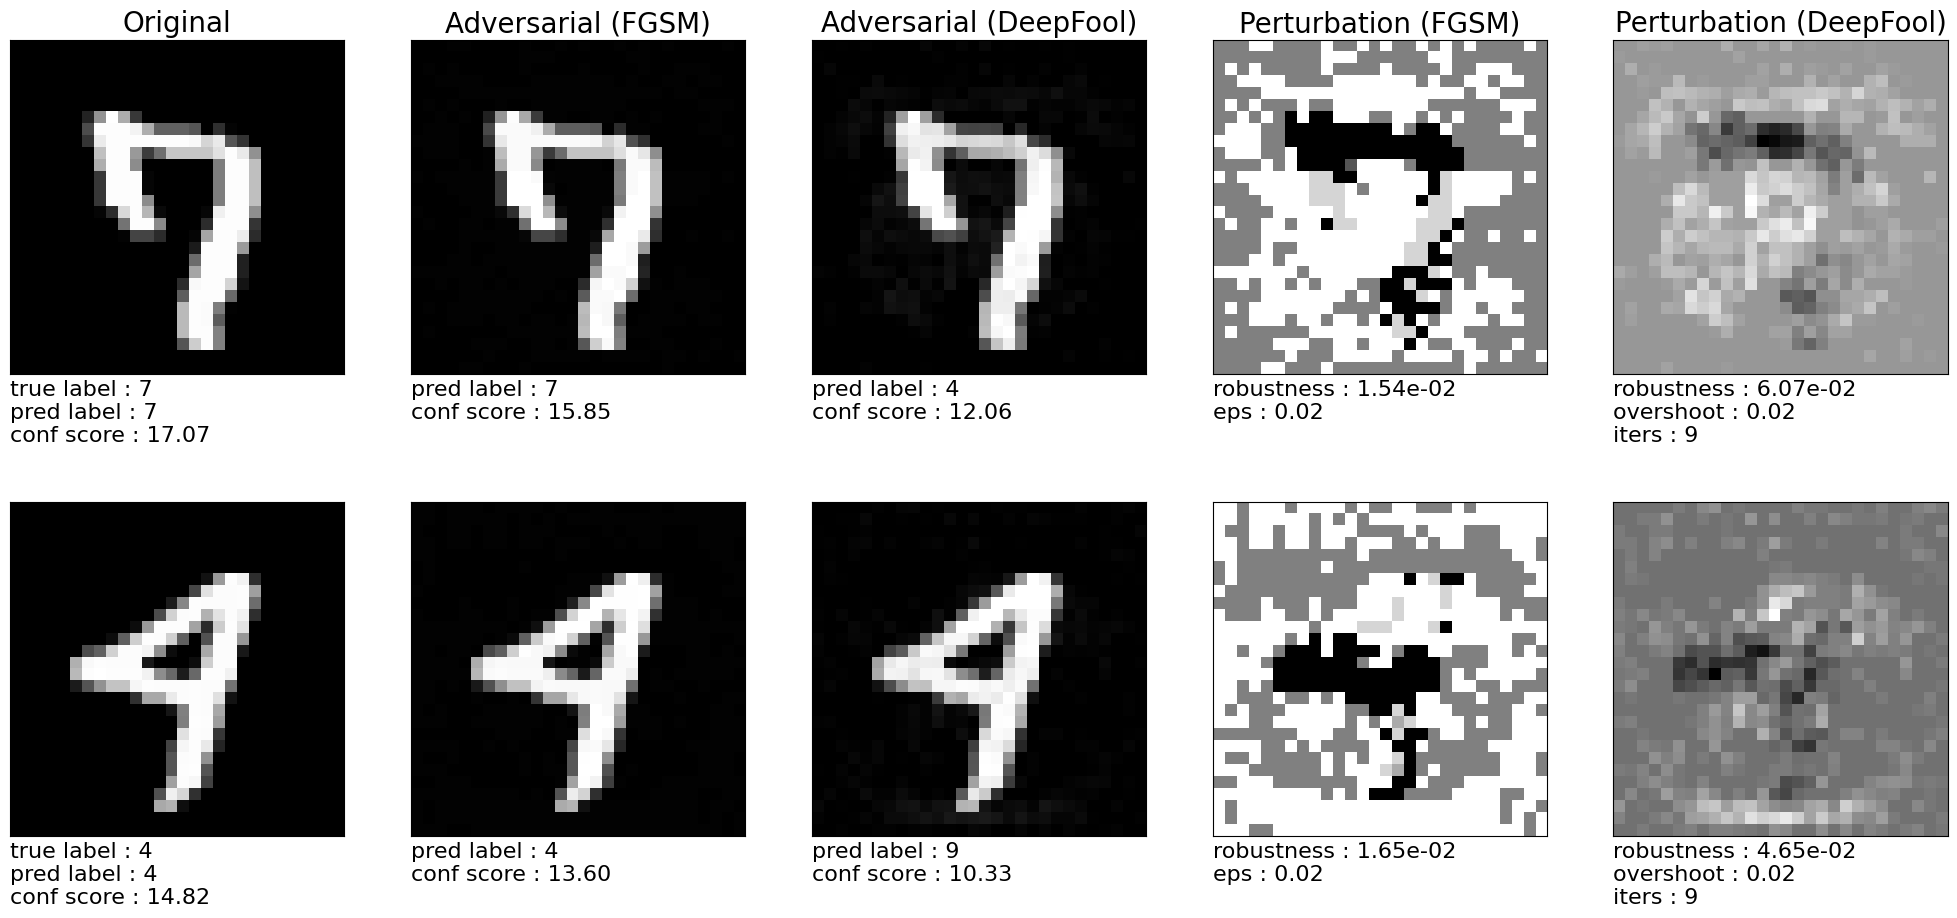

eps:  0.5


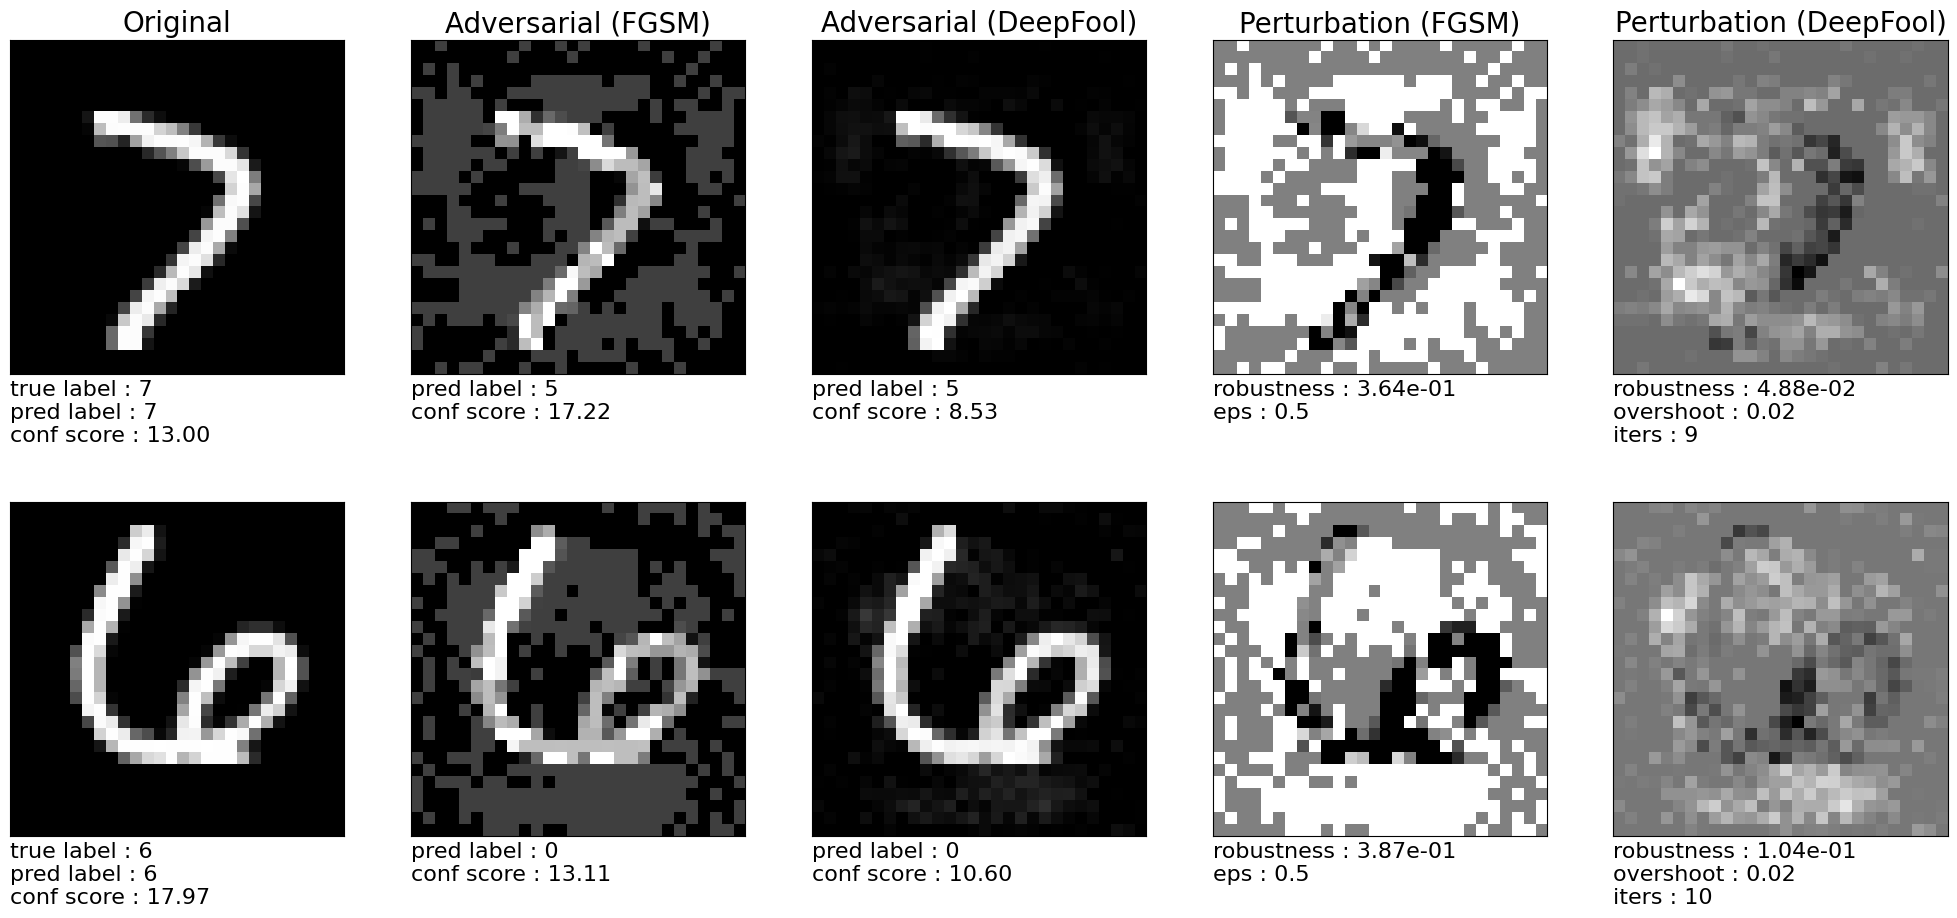

eps:  0.9


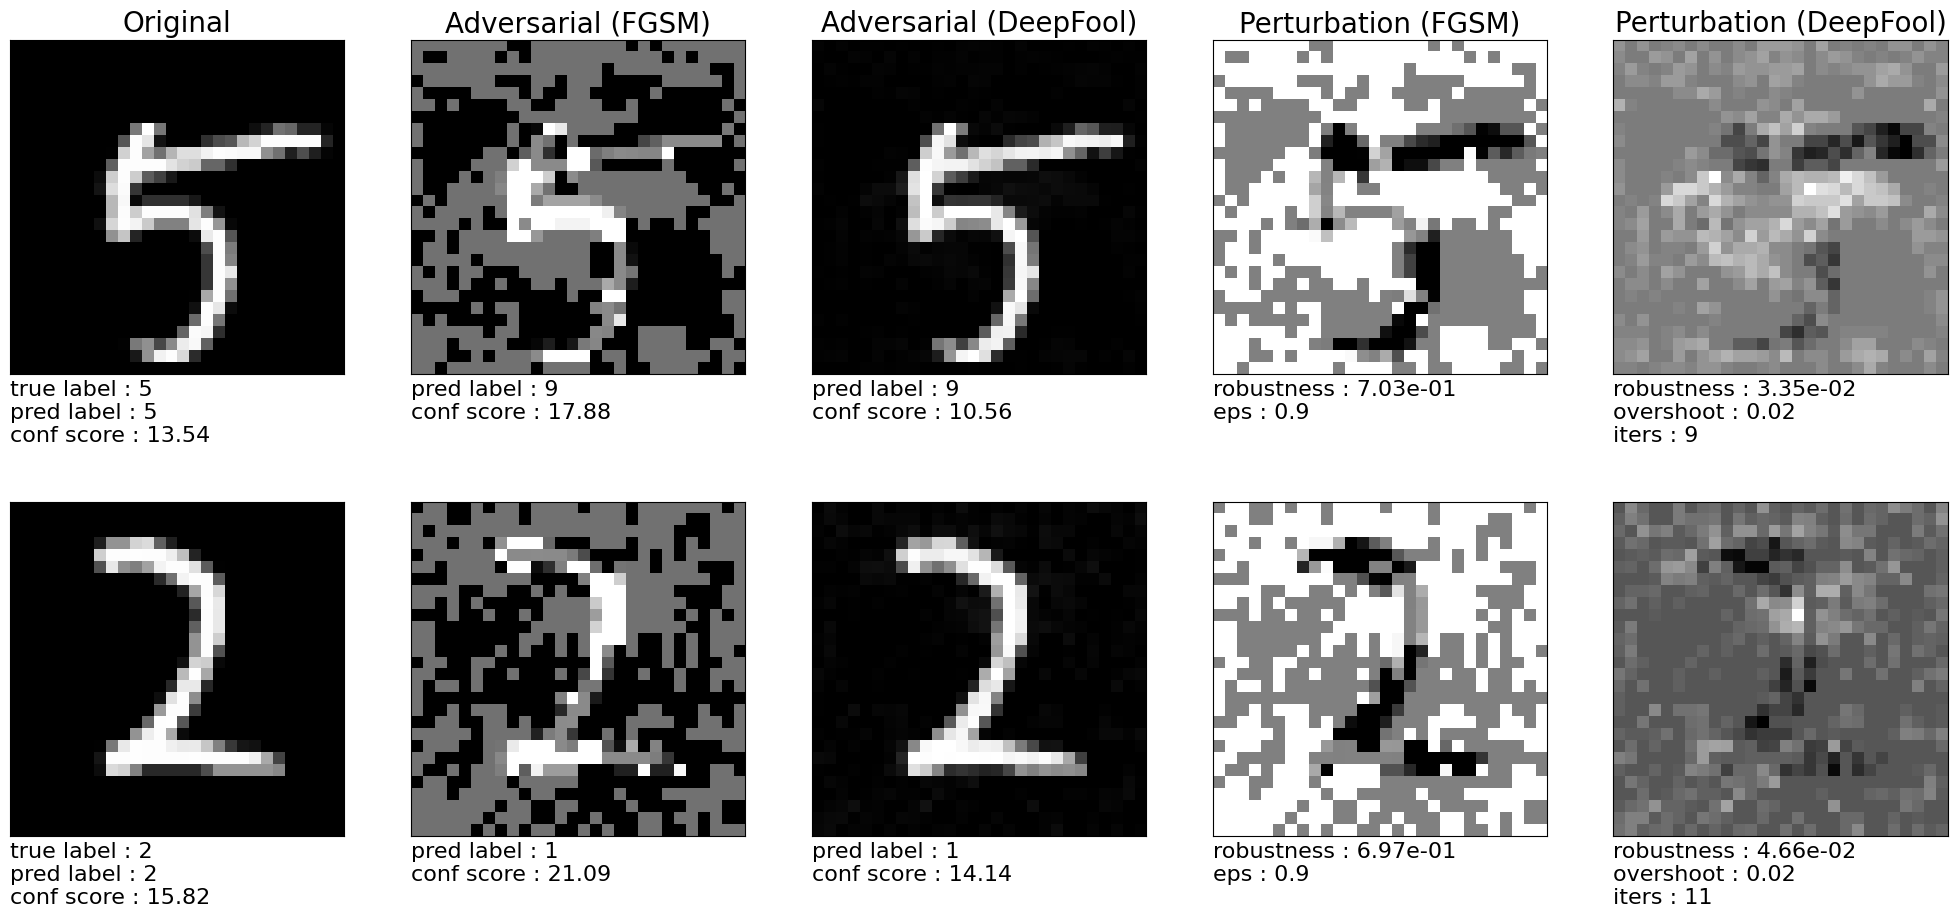

eps:  10


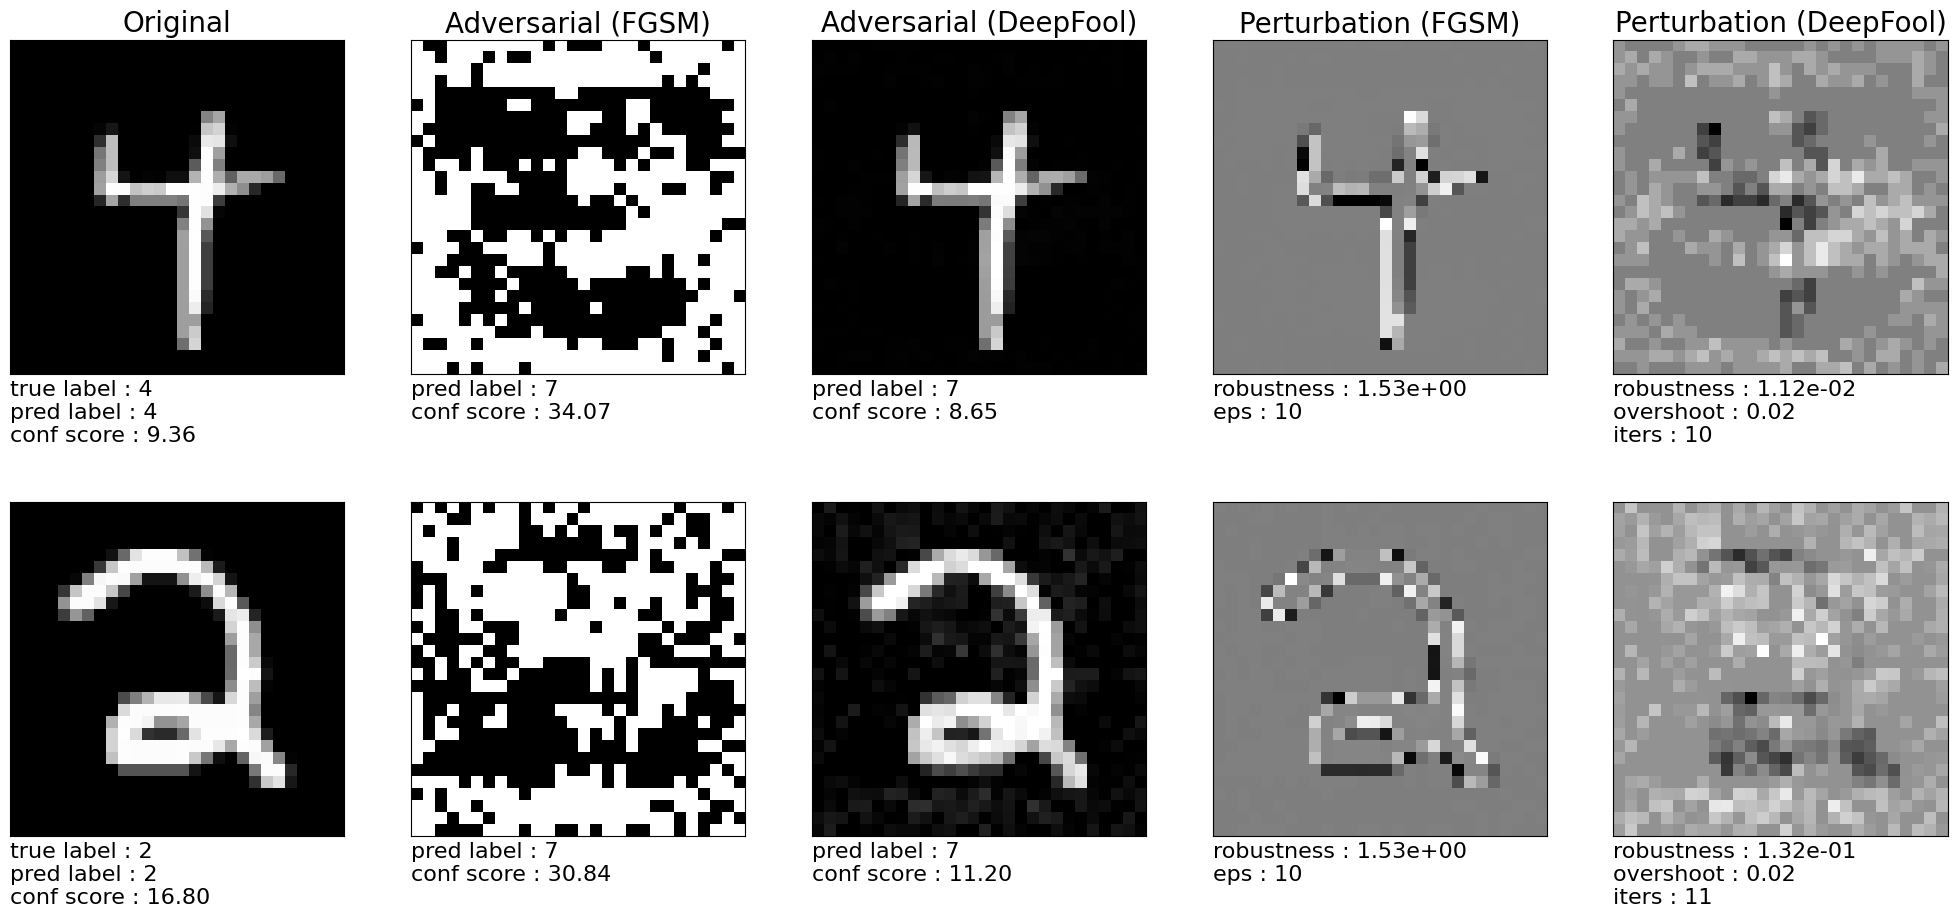

In [23]:
for fgsm_eps in fgsm_eps_arr:
  print("eps: ", fgsm_eps)

  model = FC_500_150().to(device)

  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args,

               has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)

  if device.type == 'cuda': torch.cuda.empty_cache()